In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset params
image_size = 128
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/train',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/val',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    'ProcessedSpilt_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes

# Define the search space for hyperparameters
search_space = {
    'learning_rate': [0.0005, 0.001, 0.002],
    'dropout': [0.3, 0.4, 0.5],
    'dense_units': [32, 64, 128]
}

# Helper: Build model with given hyperparameters
def build_model(lr, dropout_rate, dense_units):
    model = Sequential([
        tf.keras.Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Dragonfly Algorithm basics (simplified)
class DragonflyAlgorithm:
    def __init__(self, population_size=5, iterations=3):
        self.population_size = population_size
        self.iterations = iterations
        self.population = []  # Each member is a dict of hyperparams
        self.fitness = []

    def random_solution(self):
        return {
            'learning_rate': np.random.choice(search_space['learning_rate']),
            'dropout': np.random.choice(search_space['dropout']),
            'dense_units': np.random.choice(search_space['dense_units'])
        }

    def fitness_function(self, solution):
        # Build and train model for 2 epochs (demo only)
        model = build_model(solution['learning_rate'], solution['dropout'], solution['dense_units'])
        history = model.fit(
            train_generator,
            epochs=2,
            validation_data=val_generator,
            verbose=0
        )
        # Return validation accuracy of last epoch
        return history.history['val_accuracy'][-1]

    def optimize(self):
        # Initialize population
        self.population = [self.random_solution() for _ in range(self.population_size)]
        self.fitness = [self.fitness_function(sol) for sol in self.population]

        for iter in range(self.iterations):
            print(f"Iteration {iter + 1}/{self.iterations}")

            # Find the best solution so far
            best_idx = np.argmax(self.fitness)
            best_solution = self.population[best_idx]
            best_fitness = self.fitness[best_idx]
            print(f"Best validation accuracy so far: {best_fitness:.4f}")

            # Generate new population with simple mutation (demo)
            new_population = []
            for sol in self.population:
                new_sol = {}
                for key in sol:
                    if np.random.rand() < 0.3:  # 30% chance to mutate
                        new_sol[key] = np.random.choice(search_space[key])
                    else:
                        new_sol[key] = sol[key]
                new_population.append(new_sol)

            # Evaluate new population
            new_fitness = [self.fitness_function(sol) for sol in new_population]

            # Combine old and new populations, select best individuals
            combined_population = self.population + new_population
            combined_fitness = self.fitness + new_fitness

            # Select top population_size solutions
            sorted_indices = np.argsort(combined_fitness)[::-1]
            self.population = [combined_population[i] for i in sorted_indices[:self.population_size]]
            self.fitness = [combined_fitness[i] for i in sorted_indices[:self.population_size]]

        # Return best found solution and accuracy
        best_idx = np.argmax(self.fitness)
        return self.population[best_idx], self.fitness[best_idx]


# Run Dragonfly Algorithm
da = DragonflyAlgorithm(population_size=5, iterations=3)
best_params, best_val_acc = da.optimize()
print("Best hyperparameters found by Dragonfly Algorithm:")
print(best_params)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Train final model with best params for more epochs
final_model = build_model(best_params['learning_rate'], best_params['dropout'], best_params['dense_units'])
final_model.fit(train_generator, epochs=10, validation_data=val_generator)

# Final evaluation on test set
test_loss, test_acc = final_model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.2%}")


Found 2240 images belonging to 5 classes.
Found 480 images belonging to 5 classes.
Found 480 images belonging to 5 classes.


2025-05-25 08:33:28.324887: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-25 08:33:28.324924: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-05-25 08:33:28.324928: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-05-25 08:33:28.324954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-25 08:33:28.324976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/simarkalsi/Cd Project Soil/soil/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `supe

Iteration 1/3
Best validation accuracy so far: 0.8708
Iteration 2/3
Best validation accuracy so far: 0.9354
Iteration 3/3
Best validation accuracy so far: 0.9354
Best hyperparameters found by Dragonfly Algorithm:
{'learning_rate': 0.001, 'dropout': 0.4, 'dense_units': 128}
Best Validation Accuracy: 0.9354
Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5276 - loss: 1.5146 - val_accuracy: 0.7979 - val_loss: 0.5591
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7218 - loss: 0.7016 - val_accuracy: 0.7437 - val_loss: 0.5930
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7623 - loss: 0.5967 - val_accuracy: 0.8750 - val_loss: 0.2655
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8239 - loss: 0.5148 - val_accuracy: 0.9333 - val_loss: 0.2050
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8721 - loss: 0.3349 - val_accuracy: 0.9521 - val_loss: 0.1109
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accur

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Confusion Matrix:
[[95  0  0  1  0]
 [ 0 96  0  0  0]
 [ 0  0 96  0  0]
 [ 3  0  0 93  0]
 [ 0  0  0  0 96]]


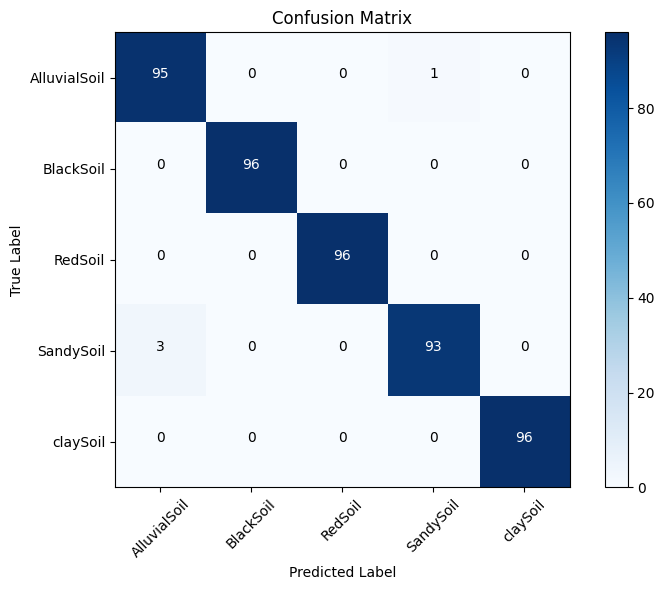


Classification Report:
              precision    recall  f1-score   support

AlluvialSoil       0.97      0.99      0.98        96
   BlackSoil       1.00      1.00      1.00        96
     RedSoil       1.00      1.00      1.00        96
   SandySoil       0.99      0.97      0.98        96
    claySoil       1.00      1.00      1.00        96

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



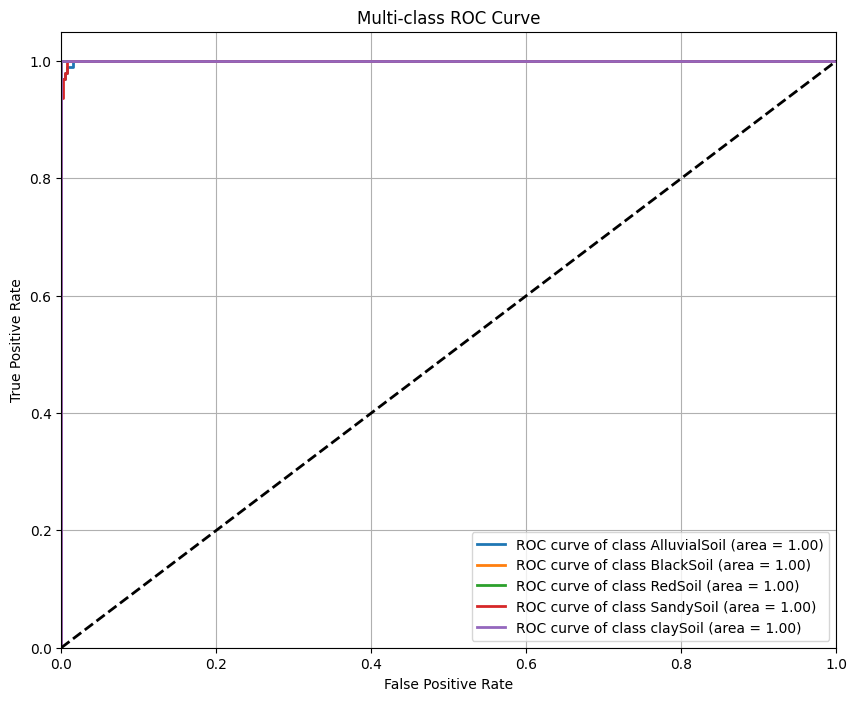

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get true labels and predictions
# Reset generator before prediction
test_generator.reset()

# True labels (integer encoded)
y_true = test_generator.classes

# Get predicted probabilities for test set
y_pred_prob = final_model.predict(test_generator, verbose=1)

# Predicted labels (class with highest probability)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Print counts inside the matrix squares
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# 2. Classification Report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# 3. ROC Curve and AUC (one-vs-rest for each class)

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10,8))
for i, class_label in enumerate(test_generator.class_indices.keys()):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_label} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
